In [25]:
import zipfile
import pandas as pd
import movie_utils
from tqdm import tqdm, trange
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# data from: https://grouplens.org/datasets/movielens/

files = {}

with zipfile.ZipFile("ml-32m.zip", 'r') as zip:
    zip_contents = zip.namelist()
    for file_name in zip_contents:
        if file_name.endswith('.csv'):
            print("Downloading " + file_name + "...")
            with zip.open(file_name) as file:
                df = pd.read_csv(file)
                files[file_name[7:-4]] = df

In [42]:
files["links"] = files["links"][["movieId", "tmdbId"]]
files["links"].head()

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [43]:
files["ratings"] = files["ratings"][["userId", "movieId", "rating"]]
files["ratings"].head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0


In [44]:
files["movies"] = files["movies"].merge(files["links"], left_on="movieId", right_on="movieId", how="inner")
files["movies"].head()

,movieId,title,genres,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357.0
4,5,Father of the Bride Part II (1995),Comedy,11862.0


In [45]:
movies = {}

for movie in files["movies"].iterrows():
    movie = movie[1]
    movies[movie.movieId] = movie_utils.Movie(movie.movieId, movie.tmdbId, movie.title, movie.genres)

In [46]:
user = files["ratings"][files["ratings"]["userId"] == 2024][:5]
for movie in user.iterrows():
    if movie[1].movieId in movies.keys():
        print("-----------------------------------------------------------------------------------------------")
        print(movies[movie[1].movieId])
        print("Rating: " + str(movie[1].rating))

-----------------------------------------------------------------------------------------------
Clerks 	1994
Comedy
Rating: 1.0
-----------------------------------------------------------------------------------------------
Exotica 	1994
Drama
Rating: 2.0
-----------------------------------------------------------------------------------------------
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) 	1994
Drama
Rating: 1.0
-----------------------------------------------------------------------------------------------
Maltese Falcon, The 	1941
Film-Noir | Mystery
Rating: 5.0
-----------------------------------------------------------------------------------------------
Gone with the Wind 	1939
Drama | Romance | War
Rating: 5.0


In [ ]:
popular_movies = files["ratings"][["movieId", "userId"]].groupby("movieId").count()
popular_movies = popular_movies.sort_values(by=["userId"], ascending=False)
popular_movies = popular_movies.index.values.tolist()

num_movies = 1000
top_popular_movies = set(popular_movies[:num_movies])

In [ ]:
total = len(files["ratings"])
ratings = np.empty((total, 3), dtype=np.float32)

i = 0
for rating in tqdm(files["ratings"].iterrows(), total=total):
    if rating[1].movieId in top_popular_movies:
        ratings[i, 0] = rating[1].userId
        ratings[i, 1] = rating[1].movieId
        ratings[i, 2] = rating[1].rating
        i += 1

ratings = ratings[:i]
np.savez_compressed("ratings.npz", ratings=ratings)

100%|██████████| 32000204/32000204 [31:23<00:00, 16992.68it/s]


In [5]:
ratings = np.load("ratings.npz")["ratings"]

In [6]:
ratings_df = pd.DataFrame(ratings, columns=["userId", "movieId", "rating"], index=[i for i in range(len(ratings))])
ratings_df["userId"] = ratings_df["userId"].astype(int)
ratings_df["movieId"] = ratings_df["movieId"].astype(int)
ratings_df.head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,32,5.0
4,1,34,2.0


In [7]:
ratings_df = ratings_df.pivot_table(index="userId", columns="movieId", values="rating")
ratings_df

movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.5,NaN,NaN,NaN,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200944,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200946,NaN,NaN,NaN,NaN,4.0,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
def isvt(X, r, max_iter=500, epsilon=1e-3):
    # Create a mask for the known entries in X
    mask = X > 0  
    prevM = np.zeros(X.shape)
    prevM[mask] = X[mask]

    progress_bar = trange(max_iter)
    
    for _ in progress_bar:
        currM = np.copy(prevM)
        
        # Perform Singular Value Decomposition
        U, S, Vt = svds(currM, k=r) # Threshold by only calculating the top r singular values
        currM = U @ np.diag(S) @ Vt

        # Fill in known values in currM from X
        currM[mask] = X[mask]
        
        # Check for convergence
        norm = np.linalg.norm(currM - prevM, ord='fro') / np.linalg.norm(prevM, ord='fro')
        if norm < epsilon:
            break
            
        progress_bar.set_description(f"[{r=:}, {norm=:.3e}]")
        
        prevM = currM
    
    return currM

In [91]:
def pick_testing_values(df, p):
    # Flatten the DataFrame to get all values with their index positions
    all_values = [(i, j, value) for i, row in df.iterrows() for j, value in row.items() if value > 0]

    # Calculate the number of values to pick based on the percentage
    num_values_to_pick = int(p * len(all_values))

    # Randomly pick the specified number of values
    picked_values = random.sample(all_values, num_values_to_pick)

   # Create a copy of the DataFrame to modify
    new_df = df.copy()

    # Replace the picked values in the new DataFrame with 0
    for i, j, _ in picked_values:
        new_df.at[i, j] = 0

    return new_df, picked_values

def calculate_error_isvt(X, r, test_proportion):
    testing_df, compare_vals = pick_testing_values(X, test_proportion)
    M = isvt(testing_df.to_numpy(), r=r)
    M = pd.DataFrame(M, columns=testing_df.columns, index=testing_df.index)
    scores = np.array([abs(rating - M.at[i, j]) for i, j, rating in compare_vals])
    avg_error = scores.mean()
    return (M, avg_error)

def cross_val_isvt(X, r_list, test_proportion=0.1, plot=True):
    errors = [] 

    for r in r_list:
        errors.append(calculate_error_isvt(X, r, test_proportion))
    
    if plot:
        plt.plot(r_list, [err for _, err in errors])
        plt.xlabel("rank")
        plt.ylabel("error")

    best = np.argmin(np.array([err for _, err in errors]))
    return (errors[best][0], r_list[best])

[r=128, norm=1.047e-02]:   4%|▍         | 21/500 [01:17<29:26,  3.69s/it]


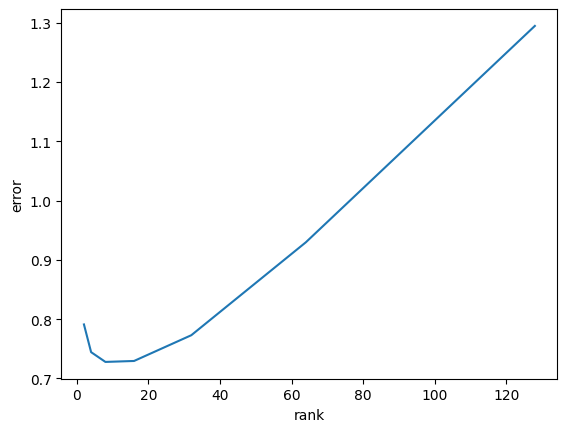

In [86]:
num_users = 20000
X = ratings_df[:num_users]
bestM = cross_val_isvt(X, r_list=[2**n for n in range(1,8)])

In [89]:
print(f"Rank: {bestM[1]}")
bestM[0]

Rank: 8


movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
1,2.444340,0.155004,0.522557,0.022716,2.241924,0.750903,0.942808,1.016050,2.380633,4.000000,...,0.127526,-0.075210,0.422834,0.691722,-0.138948,-0.169810,0.361796,0.562488,0.280151,0.338988
2,4.205458,4.508015,4.019689,4.647957,2.225479,4.584985,3.459393,4.972160,2.078458,5.394338,...,-0.270162,0.038740,-0.419348,-0.842345,0.889752,-0.006842,0.088533,-0.119116,-0.273950,0.061487
3,3.790929,3.388256,3.495079,3.637079,1.013347,3.928278,4.000000,4.000000,0.065206,3.152033,...,-0.085146,-0.461550,-0.781306,-1.636059,0.299045,0.337811,-0.188183,-2.240267,-1.202055,-0.789615
4,0.639041,0.387602,0.523261,0.029648,0.697391,0.113460,1.149892,0.067474,0.226129,-0.633296,...,-0.526147,-1.011580,-0.901516,-0.682735,-1.069262,-0.537406,-0.706864,-1.612780,-1.127383,-1.203206
5,3.197324,3.473700,2.794166,2.784398,2.730456,2.507139,4.000000,2.643477,2.056843,2.155700,...,0.054611,-0.244625,-0.494152,-0.356373,-0.101987,0.095003,-0.080828,-0.526072,-0.221663,-0.347149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,3.903062,1.937531,-0.149747,0.528134,-0.009072,0.724901,0.854652,0.729163,-0.563560,1.879686,...,3.400673,3.174445,2.813134,2.346203,3.713670,3.358102,3.792957,3.312007,3.536493,3.807608
20002,3.643658,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.830719,...,0.436489,0.402732,0.305003,0.076391,0.479386,0.484923,0.328740,0.213511,0.322532,0.357098
20003,4.067457,2.883497,3.558988,3.157634,3.972117,3.629756,3.833734,3.768474,3.044635,3.116474,...,0.407035,-0.123570,0.011522,-0.243797,-0.343268,0.389265,-0.013465,-0.873714,-0.195440,-0.260558
